# ELEC0134 - Applied Machine Learning Systems Assignment 2019/2020
## Task B2: Eye Colors Recognition

In this notebook, we are going to detect 5 different type of eye colors from the *cartoon_set* dataset:
1. Preprocessing the images by cropping out the eye region
2. Setup data generator to load **3 channels** images dataset using Keras Image Preprocessing API
3. Build an VGG-16 CNN architecture
4. Fit the CNN model to the training data
5. Test the performances of the CNN

In [1]:
# Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

### 1) Preprocess the images by cropping out eye region
We can extract relevant features from the images by using face detector from dlib library which consists of a combination of the Histogram of Oriented Gradients (HOG) feature with a linear classifier, an image pyramid,and sliding window detection scheme. 

The image below visualizes the location of 68 facial regions that dlib detects:

![facial_landmarks_68.jpg](facial_landmarks_68.jpg)

1) Right eye: [37,42] &emsp; 2) Left eye: [43,48]

We can obtain these features given an image by simply calling the ***extract_features_labels()*** function in the landmarks.py file. 
Use the dlib to extract the eye landmarks and make a bounding rectangle of it

In [2]:
import lab2_landmarks as l2

Using TensorFlow backend.


In [3]:
from lab2_landmarks import *
print(images_dir)
print(cartoon_dir)
print(labels_path)
print(crop_img)

D:\UCL\4th Year\Applied Machine Learning System\Part 1\Assignment\AMLS_assignment\Datasets\cartoon_set\img
D:\UCL\4th Year\Applied Machine Learning System\Part 1\Assignment\AMLS_assignment\Datasets\cartoon_set
D:\UCL\4th Year\Applied Machine Learning System\Part 1\Assignment\AMLS_assignment\Datasets\cartoon_set\labels.csv
D:\UCL\4th Year\Applied Machine Learning System\Part 1\Assignment\AMLS_assignment\Datasets\cartoon_set\crop_img


D:\UCL\4th Year\Applied Machine Learning System\Part 1\Assignment\AMLS_assignment\Datasets\cartoon_set\img\3034.png


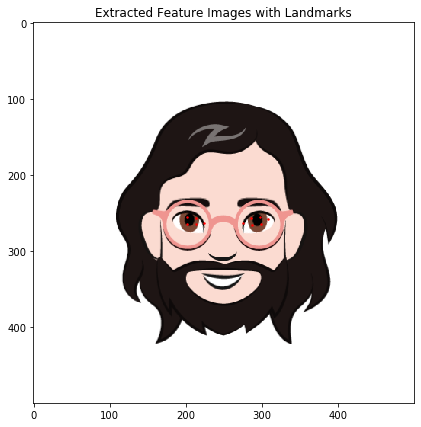

In [4]:
# Extract eye features
ex_img = os.path.join(images_dir, '3034.png')
img = image.img_to_array(image.load_img(ex_img,
                               target_size = None,
                               interpolation = 'bicubic'))
img_features, _ = l2.run_dlib_shape(img)
print(ex_img)

# Load image using cv2
actual_img = cv2.imread(ex_img)
b, g, r = cv2.split(actual_img) 
rgb_img = cv2.merge([r,g,b])
fig = plt.figure(figsize = (7,7))
fig_plot = plt.imshow(rgb_img)
plt.title('Extracted Feature Images with Landmarks')

x, y = np.split(img_features, 2, axis=1)
plt.scatter(x, y, c='r', s=2)

D:\UCL\4th Year\Applied Machine Learning System\Part 1\Assignment\AMLS_assignment\Datasets\cartoon_set\img\3034.png


Text(0.5, 1.0, 'Cropped eye images')

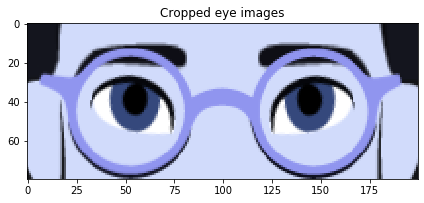

In [5]:
# Crop to get only eye region
def crop(img_path): 
    orig = cv2.imread(img_path)
    crop = orig[220:300 , 150:350]
    return crop

print(ex_img)
test_img = crop(ex_img)
fig = plt.figure(figsize = (7,7))
fig_plot = plt.imshow(test_img)
plt.title('Cropped eye images')

In [6]:
# test_path = image_paths[100]
# print(test_path)
# test_img = crop(test_path)
# fig = plt.figure(figsize = (7,7))
# fig_plot = plt.imshow(test_img)
# plt.title('Cropped eye images')

In [7]:
# Cropped all the images in the directory and save into others
# def save_crop(images_dir, dest_path):
#     image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
#     cropped_path = []
#     if os.path.isdir(images_dir):
#         for img_path in image_paths:
#             file_name= img_path.split('.')[0].split('\\')[-1]
#             cropped_img = crop(img_path)
#             new_filename = file_name + '.png'            
#             cv2.imwrite(os.path.join(dest_path, new_filename), cropped_img)
            
#     return cropped_path

In [8]:
# check_path = save_crop(images_dir, crop_img)

In [9]:
# Converting csv into dataframe using read_csv(label_path)
cartoon_df = pd.read_csv(os.path.normcase(labels_path), sep='\t', engine='python')
df = cartoon_df[['file_name', 'eye_color']]
print(df.head())

# Convert the face shape column to class 1-5
df.loc[:,'eye_color'] += 1
print(df.head())

# Convert face shape column type from int64 to str for data generator
df = df.applymap(str)

  file_name  eye_color
0     0.png          1
1     1.png          2
2     2.png          2
3     3.png          2
4     4.png          0
  file_name  eye_color
0     0.png          2
1     1.png          3
2     2.png          3
3     3.png          3
4     4.png          1


c:\users\user\anaconda3\envs\env_dlib\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### 1) Setup data generators to draws from train, test and validation dataframe
1. Convolution Neural Networks fed by batches of images to train, therefore need to convert from (size1, size2, channels) to (samples, size1, size2, channels).
2. Split the dataframe into test, train and validation set.
3. Use Keras Image Processing API (flow_from_dataframe) to load the images dataset according to dataframe

In [10]:
# Import data generator API 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# Setup data generator for train and validation dataset generator
train_df, test_df = train_test_split(df, train_size=0.7, random_state=42)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.3)                     

# Generating training and validation dataset for VGGNet CNN
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory=images_dir,
                                                    x_col="file_name",
                                                    y_col="eye_color",
                                                    target_size=(32, 32),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    subset='training')
valid_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory=images_dir,
                                                    x_col="file_name",
                                                    y_col="eye_color",
                                                    target_size=(32, 32),
                                                    batch_size=32,
                                                    shuffle=True, 
                                                    class_mode='categorical',
                                                    subset='validation')

Found 4900 validated image filenames belonging to 5 classes.
Found 2100 validated image filenames belonging to 5 classes.


### Using EarlyStopping and ModelCheckpoint Keras API callback to save the weights
Too many training epochs will lead to overfitting the training dataset whereas too few will result underfitting. Therefore, it is better to monitor the performance of the model during training and call EarlyStopping when overfitting occurs and save the weights using ModelCheckpoint

In [11]:
# Use early stopping to terminate training epochs through callbacks
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# Seek a mininum for validation loss and display the stopped epochs using verbose and adding delays
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Save best model using checkpoint
B1_dir = os.path.join(AMLS_dir, 'B2')
model_path = os.path.join(B1_dir, 'VGGNet_eye.h5')
mcp = ModelCheckpoint(os.path.normcase(model_path), monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Define callback function in a list
callback_list = [es, mcp]

### 2) Build the neural network using VGG-16 architecture
1. Build the sequential model and add convolutional and max pooling layers to it.
2. Add dropout layer at fully connected layer
3. Add softmax layer at the end
4. Compile the model and use ADAM (Adaptive learning rate optimization algorithm)

In [12]:
# Import network libraries
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

# Number of output classes
num_class = 5

# Create a sequential model
model = Sequential()

# Add 1st convolution block
model.add(Conv2D(filters=16, input_shape=train_generator.image_shape, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same"))

# Add 2nd convolution block
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same"))

# Add 3rd convolution block
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same"))

# Add 4th convolution block
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# Output Layer (5 clases for face shapes)
model.add(Flatten())
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=num_class, activation="softmax"))

# Display summary of the model
model.summary()

# Compile the model using ADAM (Adaptive learning rate optimization)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)         

### 3) Fit the VGG-16 CNN to training and validation data
Access model training history using history callback to record training metrics for each epoch

In [13]:
# Set steps per epoch for callback 
STEP_SIZE_TRAIN = train_generator.samples//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.samples//valid_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=30,
                              callbacks=callback_list,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID)

153
65
Epoch 1/30
153/153 [==============================] - 70s 455ms/step - loss: 1.6777 - accuracy: 0.2099 - val_loss: 1.9688 - val_accuracy: 0.2077

Epoch 00001: val_loss improved from inf to 1.96879, saving model to d:\ucl\4th year\applied machine learning system\part 1\assignment\amls_assignment\b2\vggnet_eye.h5
Epoch 2/30
153/153 [==============================] - 42s 276ms/step - loss: 1.5105 - accuracy: 0.2833 - val_loss: 1.9652 - val_accuracy: 0.1987

Epoch 00002: val_loss improved from 1.96879 to 1.96523, saving model to d:\ucl\4th year\applied machine learning system\part 1\assignment\amls_assignment\b2\vggnet_eye.h5
Epoch 3/30
153/153 [==============================] - 42s 275ms/step - loss: 1.2976 - accuracy: 0.4008 - val_loss: 1.6734 - val_accuracy: 0.2307

Epoch 00003: val_loss improved from 1.96523 to 1.67340, saving model to d:\ucl\4th year\applied machine learning system\part 1\assignment\amls_assignment\b2\vggnet_eye.h5
Epoch 4/30
153/153 [==========================

### 4) Performances of CNN
1. Plot the learning curve for model validation to select the optimum hyperparameters
2. Evaluating model performances using standard metrics e.g confusion matrix, accurancy score, ROC curve and etc

### Model validation

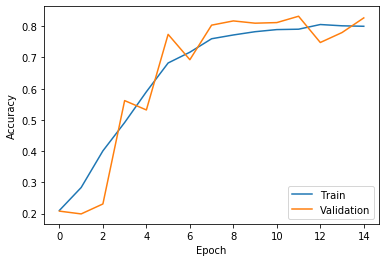

In [14]:
# Plot accuracy score versus epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

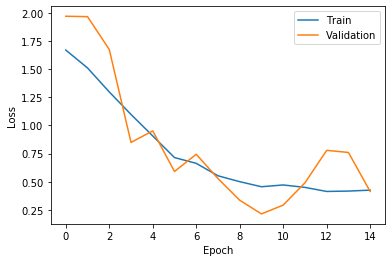

In [15]:
# Plot loss score versus epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

### Model evaluation on validation dataset

In [16]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, plot_confusion_matrix

# Evaluate the model with validation dataset
eval_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory=images_dir,
                                                    x_col="file_name",
                                                    y_col="eye_color",
                                                    target_size=(32, 32),
                                                    batch_size=1,
                                                    shuffle=True, 
                                                    class_mode='categorical',
                                                    subset='validation')
eval_model = model.evaluate_generator(generator=eval_generator, steps=STEP_SIZE_VALID, verbose=1)
print(str(model.metrics_names[0]) + ': '  + str(eval_model[0]))
print(str(model.metrics_names[1]) + ': '  + str(eval_model[1]))

Found 2100 validated image filenames belonging to 5 classes.
65/65 [==============================] - 1s 8ms/step
loss: 1.5594996213912964
accuracy: 0.8307692408561707


### Model evaluation on test dataset

In [17]:
from keras.models import load_model

# Fit the model to the test dataset by loading the model 
saved_model = load_model(model_path)

# Generate test dataset from dataframe
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                    directory=images_dir,
                                                    x_col="file_name",
                                                    y_col="eye_color",
                                                    target_size=(32, 32),
                                                    batch_size=1,
                                                    shuffle=False,
                                                    class_mode='categorical')
STEP_SIZE_TEST = test_generator.samples//test_generator.batch_size
test_generator.reset()
pred = saved_model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

# Determine the maximum activation value at the output layers for each sample
pred_class = np.argmax(pred, axis=1)   # axis = 1 give max value along each row

# True labels of test dataset
true_class = test_generator.classes


Found 3000 validated image filenames belonging to 5 classes.
3000/3000 [==============================] - 89s 30ms/step


Confusion matrix
[[500   0  94   0   8]
 [ 33 481  91   5   6]
 [ 64   3 496   3   4]
 [ 33   4 119 459   4]
 [ 31   0  96   2 464]]
Normalized confusion matrix
[[0.98266159 0.         0.18474038 0.         0.01572259]
 [0.0672501  0.98022111 0.18544724 0.01018941 0.01222729]
 [0.12796264 0.00599825 0.99171046 0.00599825 0.00799767]
 [0.0694217  0.00841475 0.25033887 0.9655928  0.00841475]
 [0.06528457 0.         0.20217158 0.00421191 0.97716265]]


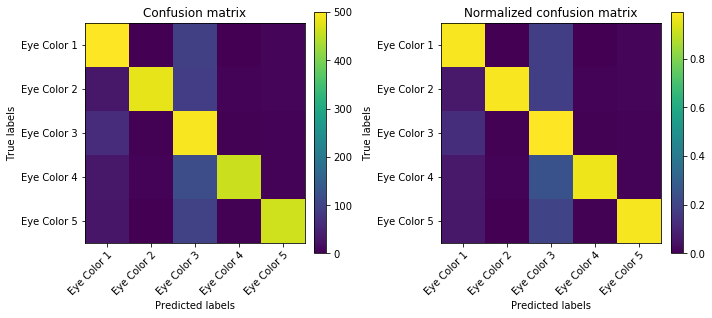

In [18]:
from sklearn.preprocessing import normalize
%matplotlib inline

def plot_cm(true_label, pred_label):
    # Plot non-normalized and normalize confusian matrix
    class_names = ['Eye Color 1', 'Eye Color 2', 'Eye Color 3', 'Eye Color 4', 'Eye Color 5']
    cm = confusion_matrix(true_label, pred_label)
    norm_cm = normalize(cm)
    
    print('Confusion matrix')
    print(cm)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    im1 = ax1.imshow(cm, interpolation="nearest")
    plt.colorbar(im1, fraction=0.05, pad=0.04, ax=ax1)
    
    ax1.set_xticks(np.arange(len(class_names)))
    ax1.set_yticks(np.arange(len(class_names)))
    ax1.set_xticklabels(class_names)
    ax1.set_yticklabels(class_names)
    ax1.set_title('Confusion matrix')
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    print('Normalized confusion matrix')
    print(norm_cm)
    
    im2 = ax2.imshow(norm_cm, interpolation="nearest")
    plt.colorbar(im2, fraction=0.05, pad=0.04, ax=ax2)
    
    ax2.set_xticks(np.arange(len(class_names)))
    ax2.set_yticks(np.arange(len(class_names)))
    ax2.set_xticklabels(class_names)
    ax2.set_yticklabels(class_names)
    ax2.set_title('Normalized confusion matrix')
    ax2.set_xlabel('Predicted labels')
    ax2.set_ylabel('True labels')
    
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    fig.tight_layout()
    plt.show()

plot_cm(true_class, pred_class)

### Import extra dataset and test 

  file_name  eye_color
0     0.png          1
1     1.png          2
2     2.png          2
3     3.png          2
4     4.png          0
  file_name  eye_color
0     0.png          2
1     1.png          3
2     2.png          3
3     3.png          3
4     4.png          1


c:\users\user\anaconda3\envs\env_dlib\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Found 10000 validated image filenames belonging to 5 classes.
10000/10000 [==============================] - 96s 10ms/step
Confusion matrix
[[1688    4  288    4   20]
 [ 103 1580  303   14   18]
 [ 234    7 1713    5   10]
 [ 101   15  344 1521   11]
 [ 116    2  303    7 1589]]
Normalized confusion matrix
[[0.98568272 0.00233574 0.16817335 0.00233574 0.01167871]
 [0.06388602 0.97999917 0.18793655 0.00868354 0.01116455]
 [0.13534156 0.00404868 0.99076963 0.00289191 0.00578383]
 [0.06462785 0.0095982  0.22011863 0.97325709 0.00703868]
 [0.07152541 0.0012332  0.18682932 0.00431619 0.97977486]]


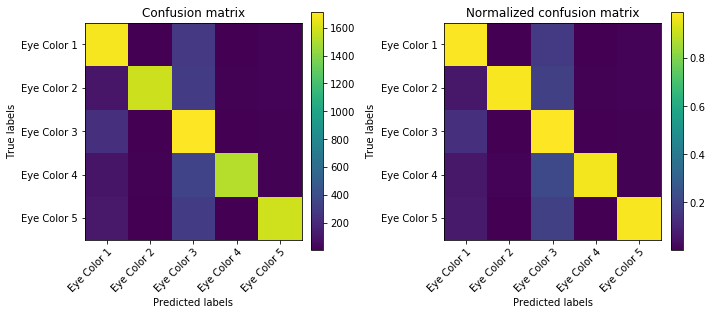

In [19]:
cartoon_test_dir = os.path.join(basedir,'cartoon_set_test')
images_test_dir = os.path.join(cartoon_dir,'img')
labels_test_filename = os.path.join(cartoon_dir,'labels.csv')

# Converting csv into dataframe using read_csv(label_path)
cartoon_new_df = pd.read_csv(os.path.normcase(labels_test_filename), sep='\t', engine='python')
new_df = cartoon_new_df[['file_name', 'eye_color']]
print(new_df.head())

# Convert the face shape column to class 1-5
new_df.loc[:,'eye_color'] += 1
print(new_df.head())

# Convert face shape column type from int64 to str for data generator
new_df = new_df.applymap(str)

# Generate extra test dataset from dataframe
new_generator = test_datagen.flow_from_dataframe(dataframe=new_df,
                                                directory=images_test_dir,
                                                x_col="file_name",
                                                y_col="eye_color",
                                                target_size=(32, 32),
                                                batch_size=1,
                                                shuffle=False,
                                                class_mode='categorical')
STEP_SIZE_NEW = new_generator.samples//new_generator.batch_size
new_generator.reset()
new_pred = saved_model.predict_generator(new_generator, steps=STEP_SIZE_NEW, verbose=1)

# Determine the maximum activation value at the output layers for each sample
new_pred_class = np.argmax(new_pred, axis=1)   # axis = 1 give max value along each row

# True labels of test dataset
new_true_class = new_generator.classes

# Plot confusion matrix
plot_cm(new_true_class, new_pred_class)